**TODO**
1. Add provenance information, export to json? Using the prov python package maybe.

In [128]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import matplotlib.pyplot as plt

# LabelSOM
----
Authors:
Johannes Le (11918056) and Terezia Olsiakova (12331438)
----

LabelSOM: print the names of the n attributes 

- A) per unit 
- B) per cluster 

as defined by one of the clustering techniques available that show 

1) the lowest variance 
2) the highest mean values within a specific unit or cluster
3) a weighted combination of these  

as text on the map units / clusters.

Parameters that should be adjustable by the user include
- the maximum number of labels to be displayed
- thresholds for the three selection types
- relative weights for the combined
selection of labels
- the amount of detail being provided (labels-only or labels + values)
- grey-scaling or font size selection depending on the label weights (mean/variance/combined).

In [282]:
class LabelSOM():
    def __init__(self, input_matrix, weight_matrix, attr_names=None):
        self.input_matrix = input_matrix
        self.weight_matrix = weight_matrix
        x_dim, y_dim, n_weight_features = weight_matrix.shape
        n_instances, n_features = input_matrix.shape

        if n_weight_features != n_features:
            raise ValueError("The weight matrix and input matrix have different feature dimensions.")

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_instances = n_instances
        self.n_features = n_features

        scaler = StandardScaler()
        self.input_matrix_scaled = scaler.fit_transform(input_matrix)
        
        if attr_names is None:
            self.attr_names = ["attr_" + str(i + 1) for i in range(0, n_features)] 
        else:
            self.attr_names = attr_names

        self.attr_names = np.array(self.attr_names)

    def extract_bmu(self):
        '''
        Maps every input vector from the input to it's best-matching unit
        in the trained SOM. The BMU is the one with the smallest Euclidean 
        distance to the input instance.

        Attributes:
            input_matrix (n_entries, n_features): contains the input data points   
            weight_matrix (x_dim, y_dim, n_features): contains the learned weights

        Returns:
            bmu_map (x_dim, y_dim): 2D list, where each cell represents a unit of SOM
                                    and contains the list of indices (range of n_entries)
                                    for which this unit is the BMU
        '''
        bmu_map = [[[] for _ in range(self.y_dim)] for _ in range(self.x_dim)]

        for i in range(self.n_instances):
            row = self.input_matrix[i]
            bmu_idx = np.linalg.norm(self.weight_matrix - row, axis=-1).argmin()
            unit_x, unit_y = np.unravel_index(bmu_idx, (self.x_dim, self.y_dim))
            bmu_map[unit_x][unit_y].append(i)

        return bmu_map

    def extract_attributes_for_unit(self, unit_bmus, n_labels, var_coeff, mean_coeff, selection_threshold):
        '''
        Extract the n attributes of the unit based on the
        desired setting.

        Attributes:
            unit_bmus: list of the indices of instances for which this unit is BMU
            n_labels: maximum number of desired labels to extract
            var_coeff: controls the selection method (see note below)
            mean_coeff: controls the selection method (see note below)
            selection_threshold: only attributes with the values above this value are considered

        Returns:
            the list of attribute, score tuples sorted as desired

        Note on the selection method (var_coeff, mean_coeff):
            (1, 0) -> select lowest variance
            (0, 1) -> select highest mean
            (x, y) -> combined selection with the given weights, sorted ascendingly
        '''
        instances = [self.input_matrix_scaled[i] for i in unit_bmus]
        data = np.stack(instances)

        vars = np.var(data, axis=0)
        means = np.mean(data, axis=0)

        values = var_coeff * vars + mean_coeff * means
        threshold_mask = values > selection_threshold
        sorting_mask = np.argsort(values[threshold_mask])

        if var_coeff == 0 and mean_coeff == 1:
            # we want highest variance -> inverse order
            sorting_mask = sorting_mask[::-1]

        sorted_names = self.attr_names[threshold_mask][sorting_mask][:n_labels]
        sorted_values = values[threshold_mask][sorting_mask][:n_labels]
        
        return list(zip(sorted_names, sorted_values))
        
    def display_per_unit(self, n_labels, selection_threshold=0,
                         var_coeff=0, mean_coeff=1, 
                         scale_text=True, display_values=False):
        '''
        Displays the labelled SOM according to the user's settings.

        Attributes:
            n_labels: maximum number of desired labels to display (per unit)
            selection_threshold: only consider labels with calculated values above this one
            var_coeff: selection method configuration (see also extract_attributes_for_unit())
            mean_coeff: selection method configuration (see also extract_attributes_for_unit())
            scale_text: whether label text should be scaled according to its value
            display_values: whether values should be displayed togehter with the label
        
        Return:
            nothing (the plot is shown)
        '''
        bmu_map = self.extract_bmu()

        labels_dict = {}
        for i, row in enumerate(bmu_map):
            for j, bmus in enumerate(row):
                if not bmus:
                    # empty unit since no input instances have it as their BMU
                    continue
                labels_dict[(i, j)] = self.extract_attributes_for_unit(bmus, n_labels, var_coeff, mean_coeff, selection_threshold)
        
        self._plot_texts(labels_dict, scale_text, display_values)
        
    def _plot_texts(self, labels_dict, scale_text, display_values):
        '''
        Helper method that plots the labels in the corresponding unit
        of the SOM.

        Attributes:
            labels_dict: created in display_per_unit(), contains information 
                         on which cell should contain which labels
            scale_text: user setting for scaling text (see also display_per_unit())
            display_values: user setting for displaying values (see also display_per_unit())

        Return:
            nothing (the plot is shown)
        '''
        fig, ax = plt.subplots(figsize=(self.x_dim, self.y_dim))

        ax.set_xticks(range(self.x_dim + 1))
        ax.set_yticks(range(self.y_dim + 1))
        ax.grid(True, which='both')

        ax.set_xlim(0, self.x_dim)
        ax.set_ylim(0, self.y_dim)

        ax.grid(linewidth=1, linestyle='-', color='black')
        plt.gca().invert_yaxis()

        for coords, labels in labels_dict.items():
            x, y = coords
            seg_height = 1 / (len(labels) + 1)
            for idx, (label, weight) in enumerate(labels):
                fontsize = 9 if not display_values else 4
                if scale_text:
                    fontsize += 4 * weight
                text = label
                if display_values:
                    text += f" {weight:.2f}"
                ax.text(x + 0.5, y + (idx + 1) * seg_height, text, ha='center', va='center', color='red', fontsize=fontsize)

        plt.show()

**Evaluation** 
1. Pick the Chainlink Data Set (/datasets/chainlink) and the 10-Clusters dataset (/datasets/10clusters).
2. Train a 10x10 (small) and a 100x60 (large) SOM. Make sure that the SOMs are properly trained, i.e. that the structures to be expected in the SOM become clearly visible by identifying suitable parameters for the initial neighborhood radius and initial learning rate.
3. Show the visualizations, providing examples with different parameter settings and comparisons that allow a validation of the correctness of the implementation. Specifically, test a few extreme values for the parameter settings.
-------

Not planned: *Where an identical visualization exists in the JÁVA SOM toolbox, read a SOM pre-trained
with the JAVA SOM Toolbox (import functions are provided in the notebook) and compare
your visualization with the one produced by the Java SOMToolbox* 

-> I don't think the LabelSOM exists in this PySOMVis package (checked the visualization folder) and I could not dowload the Java SOM executable, it kept failing to download xD There are some examples in the slides (s. 189-191) using the animals dataset, but it is hard to tell what the training was, so we could probably not get a fair comparison. 

In [266]:
from SOMToolBox_Parse import SOMToolBox_Parse
idata   = SOMToolBox_Parse("datasets/10clusters/10clusters.vec").read_weight_file()
classes = SOMToolBox_Parse("datasets/10clusters/10clusters.cls").read_weight_file()

In [267]:
som = MiniSom(100, 60, idata['vec_dim'])
som.train(idata['arr'], 10000)

weights = som.get_weights()

In [283]:
label_som_big = LabelSOM(idata["arr"], weights)

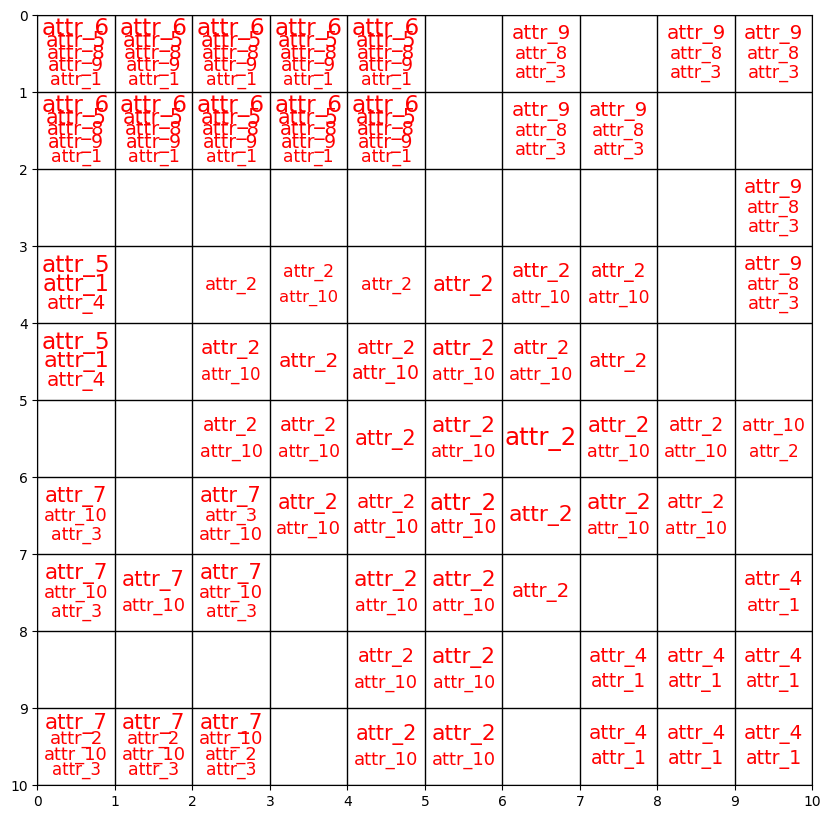

In [284]:
label_dict = label_som_big.display_per_unit(5, selection_threshold=0.7)

In [285]:
som = MiniSom(10, 10, idata['vec_dim'])
som.train(idata['arr'], 10000)

weights = som.get_weights()

In [286]:
label_som_small = LabelSOM(idata["arr"], weights)

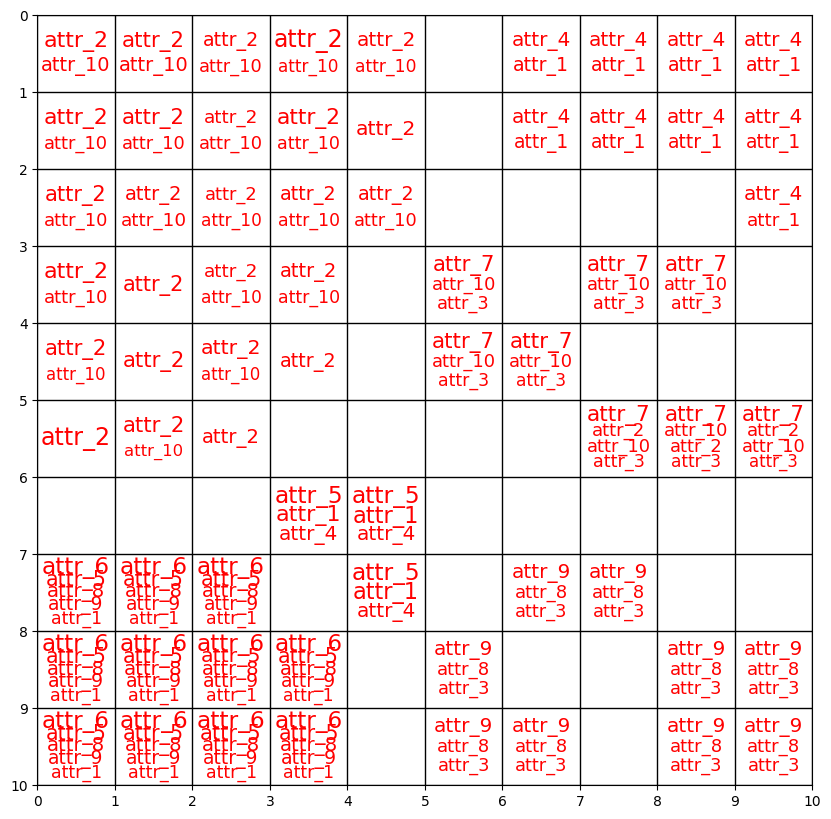

In [287]:
label_dict = label_som_small.display_per_unit(5, selection_threshold=0.7)

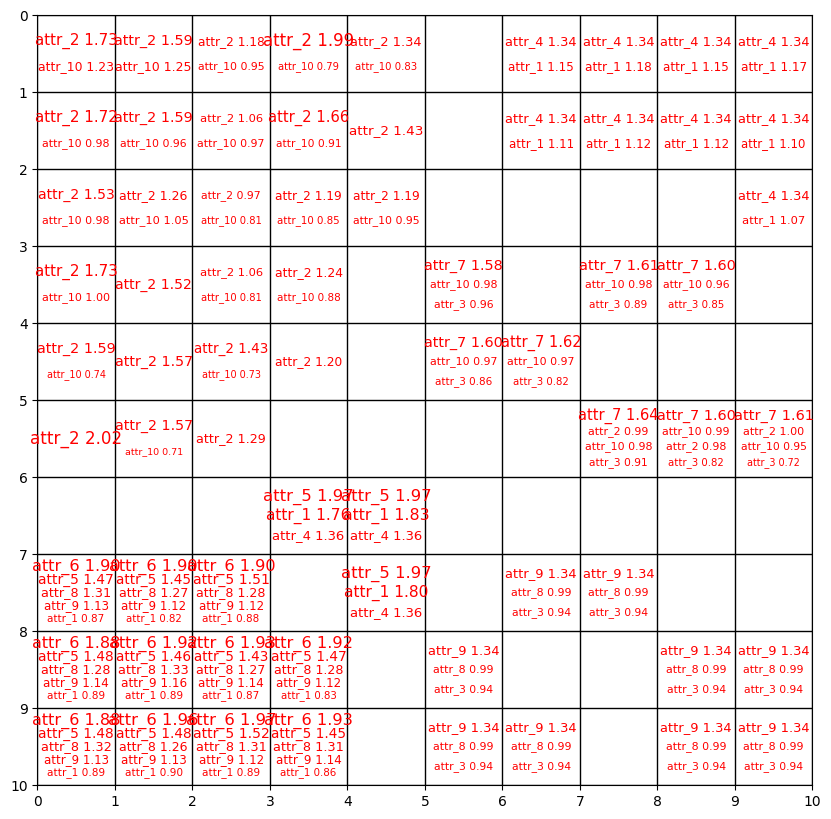

In [288]:
label_som_small.display_per_unit(5, selection_threshold=0.7, display_values=True)

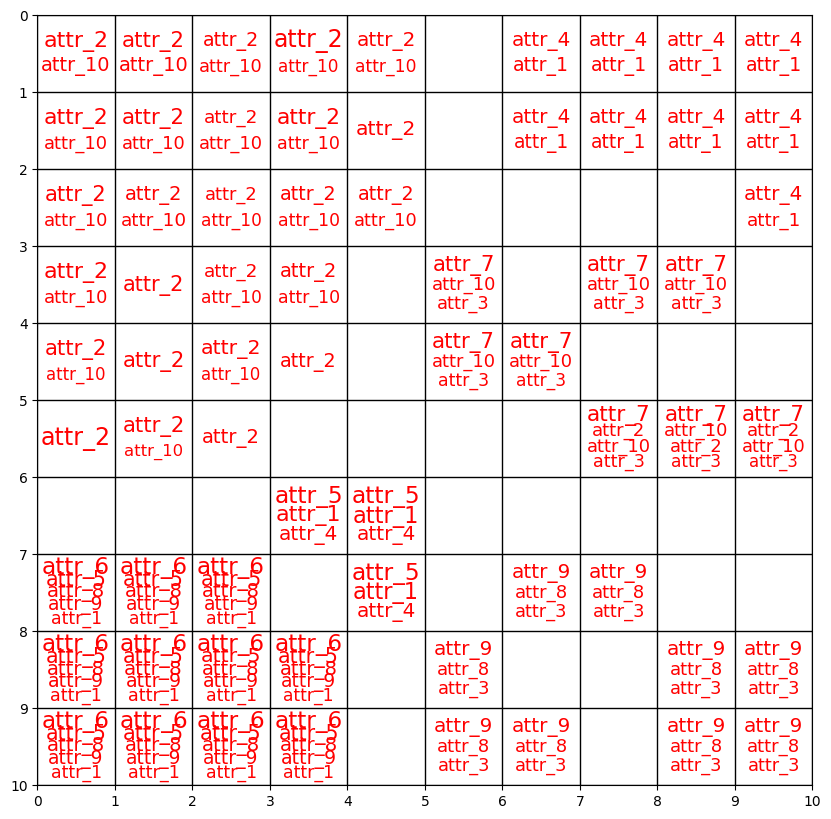

In [289]:
label_som = LabelSOM(idata["arr"], weights)
label_som.display_per_unit(5, selection_threshold=0.7)

In [259]:
# Visualization by PySOMVis
from pysomvis import PySOMVis

vis = PySOMVis(weights=weights.reshape(100, 10), m=10, n=10,
                dimension=10, input_data=idata['arr'],
                classes=classes['arr'][:,1])
vis._onbigscreen()

Launching server at http://localhost:44937


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_alpha" value "alpha" [renderer: GlyphRenderer(id='3487', ...)]
